# Simulationデータの作成


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import colorsys
import random
from scipy.spatial import distance
import ot
from sklearn.manifold import MDS
import sys

sys.path.append("../")
from src.Barycenter_alignment import Barycenter_alignment
from src.GW_alignment import GW_alignment

2023-02-06 17:32:42.975190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 17:32:43.305609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 17:32:43.305691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 17:32:43.350486: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 17:32:44.598628: W tensorflow/stream_executor/platform/de

In [2]:
# Parameters
n_colors = 100 ## 色の数
n_sub = 5 ## 個体数
n_dim = 3 ## embeddingの次元

In [3]:
# The function for creating color labels
def get_color_labels(n):
    # Set the saturation and lightness values to maximum
    saturation = 1.0
    lightness = 0.5

    # Calculate the hue step size
    hue_step = 1.0 / n

    # Create a list to store the color labels
    color_labels = []

    # Generate the color labels
    for i in range(n):
        hue = i * hue_step
        r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
        color_labels.append((r, g, b))

    return color_labels


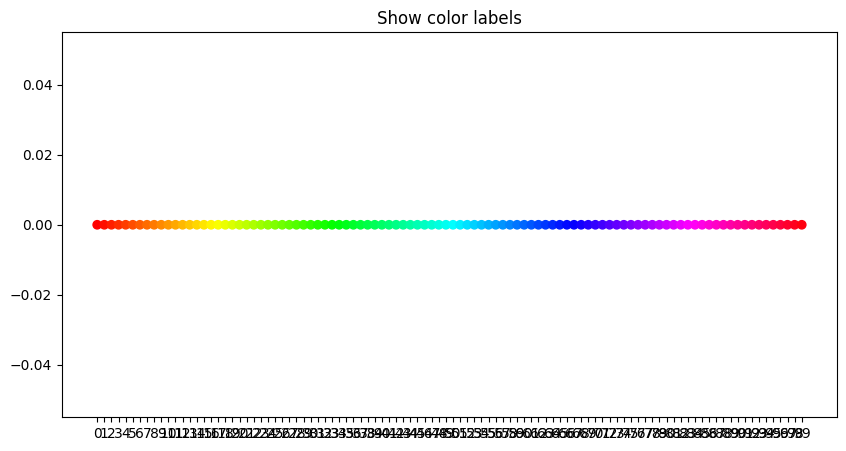

In [4]:
# Show color labels
color_label = get_color_labels(n_colors)
plt.figure(figsize=(10, 5))
plt.scatter(np.linspace(0, n_colors-1, n_colors), np.zeros((n_colors,)), c = color_label)
plt.xticks(ticks = np.linspace(0, n_colors-1, n_colors))
plt.title("Show color labels")
plt.show()

In [5]:
# 三次元空間の円
def create_circle(n_points, lamb, shift_adjustment, radius=5):
    random_rotation = np.random.uniform(0, 2 * np.pi)
    theta = np.linspace(0, 2 * np.pi, n_points) + lamb*shift_adjustment + np.array([random_rotation for _ in range(n_points)])
    points = np.zeros((n_points, 3))
    points[:, 0] = radius * np.sin(theta)
    points[:, 1] = radius * np.cos(theta)
    points[:, 2] = 0
    return points

def perturb_points(points, mu = 0, sig = 1, corr_noise = 0):
    """
    A fuction for adding random noise to points on a cirlce.
    """
    n_points = points.shape[0]
    corr_points = np.zeros(points.shape)
    for i in range(n_points):
        corr_points[i, 0] = points[i, 0] +  np.random.normal(mu, sig) + corr_noise
        corr_points[i, 1] = points[i, 1] +  np.random.normal(mu, sig) + corr_noise
        corr_points[i, 2] = points[i, 2] +  np.random.normal(mu, sig) + corr_noise
    return corr_points

In [6]:
# 被験者ごとの色のembedding
embedding_list = np.zeros((n_sub, n_colors, n_dim)) # [(n_colors, n_dim) for i in range(n_sub)]
shift_adjustment = np.random.rand(n_colors) # 色の構造を複雑にする
corr_noise = np.random.normal(0, 0.1) # 共通のノイズ
for i in range(n_sub):
    emb = create_circle(n_colors, lamb = 0.7, shift_adjustment = shift_adjustment) 
    emb = perturb_points(emb, mu = 0, sig = 0.01, corr_noise = corr_noise)
    embedding_list[i] = emb

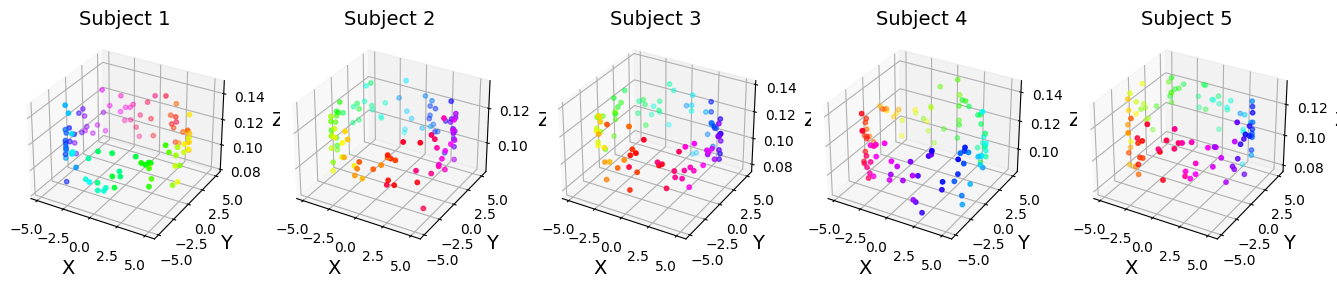

In [7]:
# simmulationデータの可視化
# each subject
fig = plt.figure(figsize=(20, 20))
for i in range(n_sub):
    ax = fig.add_subplot(6, 6, i + 1, projection='3d')
    coords_i = embedding_list[i]
    title = "Subject {}".format(i+1)

    ax.scatter(xs=coords_i[:, 0], ys=coords_i[:, 1], zs=coords_i[:, 2],
           marker="o", color=color_label, s=10)
    ax.set_xlabel("X", fontsize=14)
    ax.set_ylabel("Y", fontsize=14)
    ax.set_zlabel("Z", fontsize=14)
    plt.title(title, fontsize=14)
plt.show()

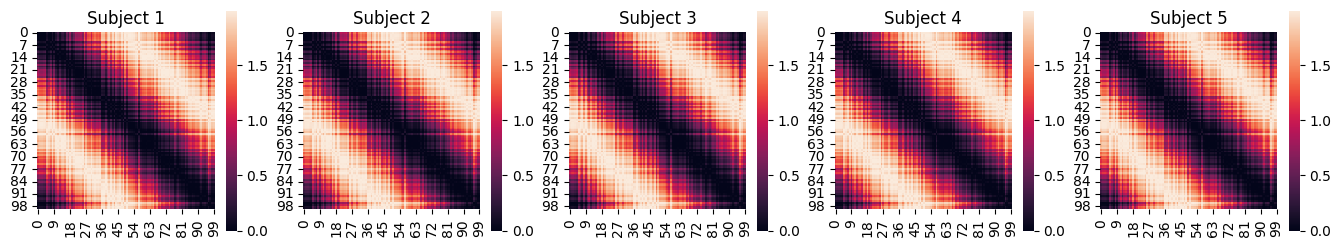

In [8]:
sim_mat_list = np.zeros((n_sub, n_colors, n_colors))
for i in range(n_sub):
    sim_mat_list[i] = distance.cdist(embedding_list[i], embedding_list[i], 'cosine')
    
# Show simmilarity matrices
fig = plt.figure(figsize=(20, 20))
for i in range(n_sub):
    ax = fig.add_subplot(6, 6, i + 1)
    sns.heatmap(sim_mat_list[i], square=True, ax = ax)
    plt.title("Subject {}".format(i + 1))
plt.show()

# Barycenter alignment

In [9]:
# Set parameters
n_init_plan = 5 #  the number of initial plans
epsilons = np.linspace(1e-2, 5e-3, 3)
epsilon_range = [1e-4, 1e-2] # search range of epsilon
n_trials = 3 # number of epsilons
n_jobs = 10 # the number of cores
init_diag = True 

DATABASE_URL = 'mysql+pymysql://root@localhost/takeda_GWOT'
name_list = [f"Subject{i + 1}" for i in range(n_sub)]

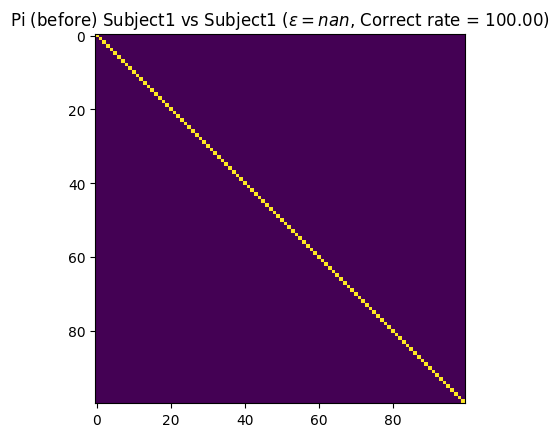

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


/home/takeda/.venv/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


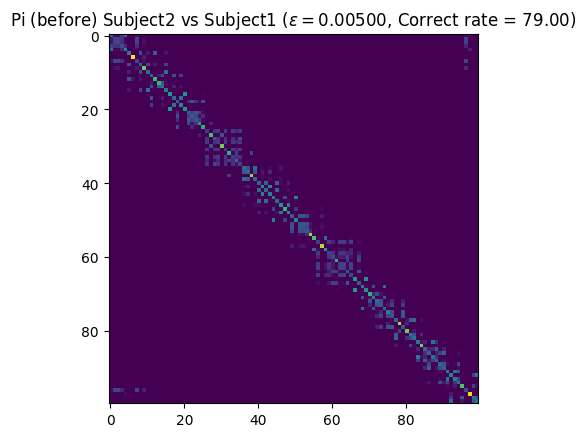

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


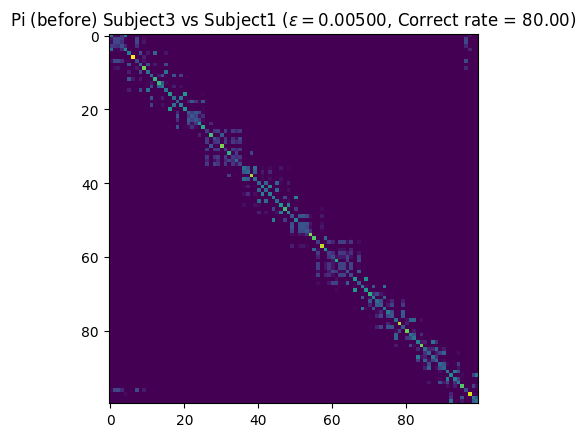

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


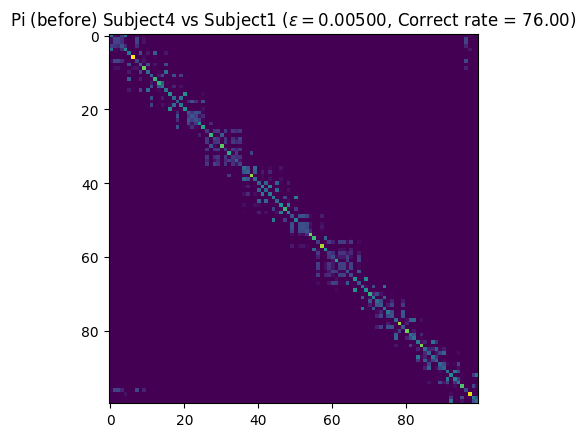

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


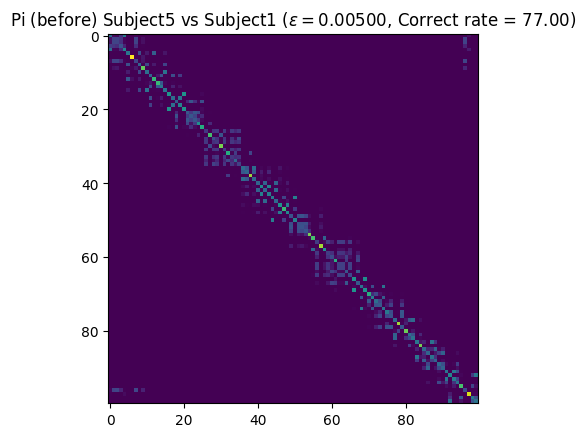

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


In [10]:
# Set the instance
barycenter = Barycenter_alignment(n_sub, embedding_list, pivot = 0, DATABASE_URL = DATABASE_URL, name_list = name_list)

# GW alignment to the pivot
# With optuna
#Pi_list_before = barycenter.gw_alignment_to_pivot(optuna = True, 
#                                                  n_init_plan = n_init_plan, 
#                                                  epsilon_range = epsilon_range, 
#                                                  n_trials = n_trials, 
#                                                  n_jobs = n_jobs, 
#                                                  init_diag = init_diag)

# Without using optuna
Pi_list_before = barycenter.gw_alignment_to_pivot(optuna = False, 
                                                  n_init_plan = n_init_plan, 
                                                  epsilons = epsilons, 
                                                  n_trials = n_trials, 
                                                  n_jobs = n_jobs, 
                                                  init_diag = init_diag)

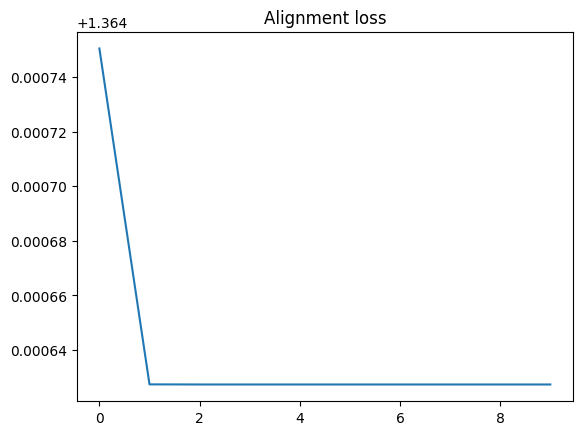

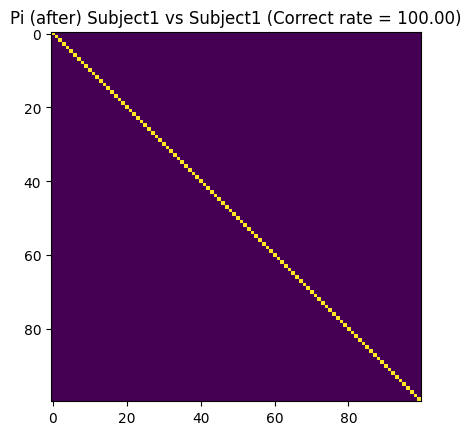

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


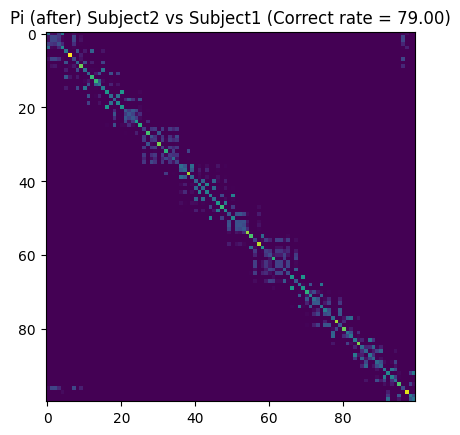

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


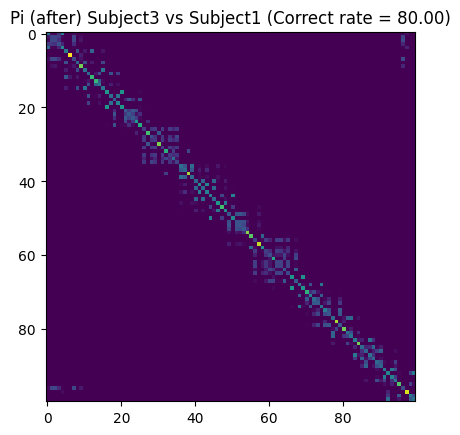

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


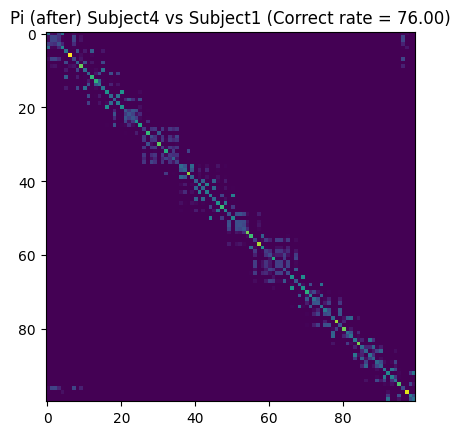

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


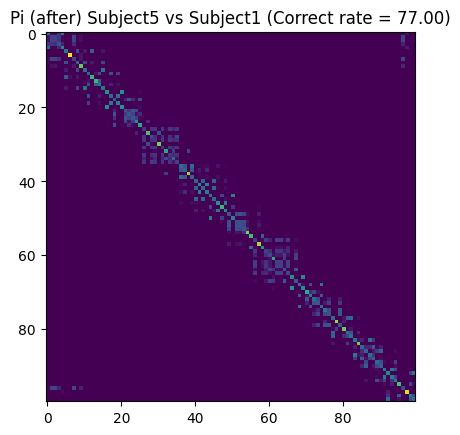

Top 10 :  100.0
Top 20 :  100.0
Top 30 :  100.0
Top 40 :  100.0
Top 50 :  100.0


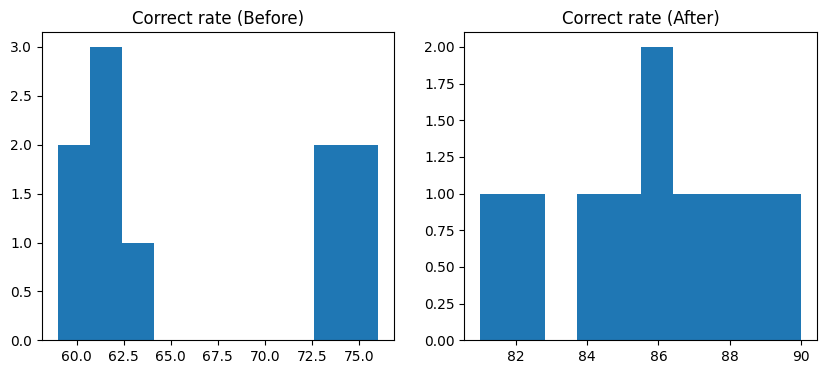

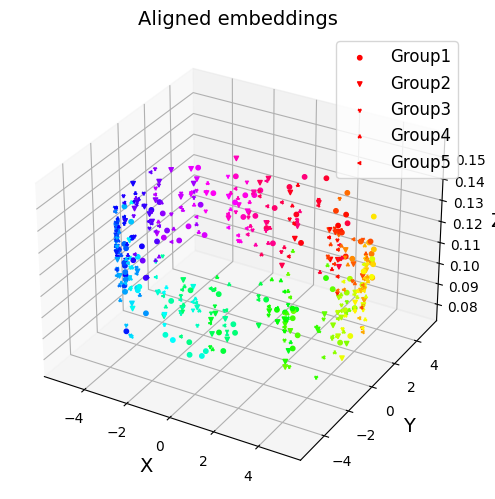

In [11]:
# Barycenter alignment
Pi_list_after = barycenter.main_compute(Pi_list_before, max_iter = 10)
barycenter.calc_correct_rate_for_pairs(Pi_list_before, Pi_list_after)

# Plot
markers_list = ["o", "v", "1","2","3","4","<",">","^","8","s","p","P","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8]
barycenter.plot_embeddings(markers_list, color_label)